# Importing Libraries

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam , Adagrad, SGD, RMSprop
from keras.layers import Dense, Dropout, BatchNormalization, LSTM, Activation
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing

In [2]:
data = pd.read_csv("Consumption_Climate_Average_West_Bengal_2018_2019_2020.csv")
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace = True)
data.drop("avg_temp", axis = 1, inplace = True)
data

,Consumption,avg_max,avg_min,avg_rain
Date,,,,
2018-01-01,87.3,23.775773,11.385371,0.0
2018-01-02,87.9,23.422979,11.027654,0.0
2018-01-03,92.1,21.428075,10.351028,0.0
2018-01-04,96.6,20.518272,9.465577,0.0
2018-01-05,98.5,21.488783,8.556001,0.0
...,...,...,...,...
2020-12-27,110.0,23.572216,10.109815,0.0
2020-12-28,111.1,23.569913,9.930083,0.0
2020-12-29,116.1,23.504397,10.118490,0.0


In [3]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.25, random_state= 69)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(640, 3)
(640,)
(214, 3)
(214,)
(151, 3)
(151,)


In [4]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train_reshaped =np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
X_reshaped = np.array(X).reshape(X.shape[0], 1, X.shape[1])
X_val_reshaped = np.array(X_val).reshape(X_val.shape[0], 1, X_val.shape[1])


print(X_train_reshaped.shape)
print(X_test_reshaped.shape)
print(X_reshaped.shape)
print(X_val_reshaped.shape)

(640, 1, 3)
(151, 1, 3)
(1005, 1, 3)
(214, 1, 3)


# LSTM

In [5]:
keras.backend.clear_session()

In [6]:
#Initialize LSTM:
model = Sequential()

model.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (1, X_train.shape[1])))

model.add(LSTM(units = 50, activation='relu', return_sequences=True))

model.add(LSTM(units = 50, activation='relu', return_sequences= True))

model.add(LSTM(units = 25, return_sequences= True))

model.add(LSTM(units = 20))

#Adding the output layer
model.add(Dense(units = 20, activation="relu"))
model.add(Dense(units = 10, activation= "relu"))
model.add(Dense(units = 5))
model.add(Dense(units = 1))

#Compile
model.compile(optimizer='adam', loss='mean_squared_error')

#Fitting
callback = EarlyStopping(monitor = "loss", patience = 25, restore_best_weights=True) 

history = model.fit(X_train_reshaped, y_train, validation_data= (X_val_reshaped, y_val) , epochs=500, batch_size=32, callbacks = [callback])

Epoch 1/500
20/20 [==============================] - 20s 240ms/step - loss: 20163.8477 - val_loss: 19598.1855
Epoch 2/500
20/20 [==============================] - 0s 19ms/step - loss: 20081.2383 - val_loss: 19373.8203
Epoch 3/500
20/20 [==============================] - 0s 24ms/step - loss: 19607.5254 - val_loss: 18663.2031
Epoch 4/500
20/20 [==============================] - 0s 23ms/step - loss: 18686.9336 - val_loss: 17503.9395
Epoch 5/500
20/20 [==============================] - 1s 27ms/step - loss: 17198.6758 - val_loss: 15670.8965
Epoch 6/500
20/20 [==============================] - 0s 23ms/step - loss: 14986.6768 - val_loss: 13135.4932
Epoch 7/500
20/20 [==============================] - 0s 23ms/step - loss: 12114.0967 - val_loss: 10027.1572
Epoch 8/500
20/20 [==============================] - 1s 25ms/step - loss: 8805.6387 - val_loss: 6696.8447
Epoch 9/500
20/20 [==============================] - 0s 14ms/step - loss: 5526.2573 - val_loss: 3725.6665
Epoch 10/500
20/20 [==========

In [7]:
ls_hist = pd.DataFrame(history.history)
ls_hist

,loss,val_loss
0,20163.847656,19598.185547
1,20081.238281,19373.820312
2,19607.525391,18663.203125
3,18686.933594,17503.939453
4,17198.675781,15670.896484
...,...,...
93,150.826324,154.067062
94,149.204620,166.711395
95,150.046799,168.456116
96,149.860641,148.570801


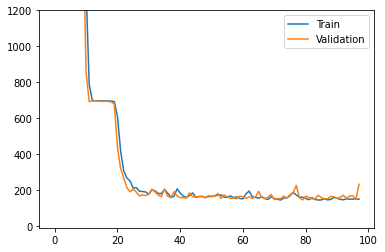

In [8]:
plt.plot(ls_hist.index, ls_hist["loss"], label = "Train")
plt.plot(ls_hist.index, ls_hist["val_loss"], label = "Validation")
plt.ylim([-10, 1200])
plt.legend()

# The Model is neither Overfitting nor Underfitting

# Predictions

In [9]:
### Lets Do the prediction
train_predict = model.predict(X_train_reshaped)
val_predict = model.predict(X_val_reshaped)
test_predict = model.predict(X_test_reshaped)

In [10]:
r2_score(test_predict, y_test)

0.849050617479101

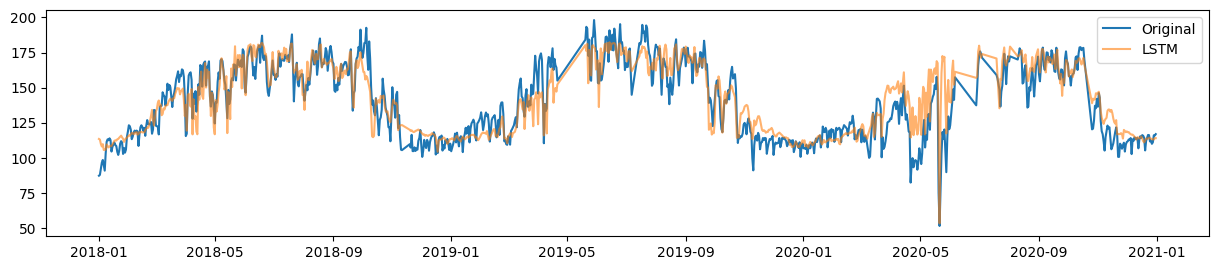

In [11]:
plt.figure(figsize = (15, 3), dpi = 100)
plt.plot(X.index, y, label = "Original")
plt.plot(X.index, model.predict(X_reshaped), alpha = 0.6, label = "LSTM")
plt.legend()

In [ ]:
model.save("Power_lstm_wb.h5")
print("Model Saved....")

Model Saved....


In [ ]:
new_kol = pd.read_csv("22-08_28-08_climate.csv")
new_kol["Date"] = pd.to_datetime(new_kol["Date"])
new_kol.set_index("Date", inplace = True)
new_kol

,max_temp,min_temp,rain
Date,,,
2022-08-22,35,27,0.5
2022-08-23,31,27,0.7
2022-08-24,31,26,4.9
2022-08-25,32,26,0.2
2022-08-26,34,26,0.1
2022-08-27,34,27,0.1
2022-08-28,32,27,2.6


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("Power_lstm_wb.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             11000     
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_3 (LSTM)               (None, 1, 25)             7600      
                                                                 
 lstm_4 (LSTM)               (None, 20)                3680      
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 10)                2

In [ ]:
new_kol["avg_temp"] = (new_kol["max_temp"] + new_kol["min_temp"])/2
kol_arr = np.array(new_kol).reshape(new_kol.shape[0], 1, new_kol.shape[1])
kol_arr.shape

(7, 1, 4)

In [ ]:
model.predict(kol_arr)

array([[178.404  ],
       [172.37639],
       [163.00471],
       [171.70088],
       [176.03473],
       [177.59547],
       [173.68655]], dtype=float32)